###  Step 1: Imports & Config
bring in core libs, set seeds for reproducibility, point to your CSVs, and define evaluation/train configs.

In [16]:
# Core
import math
import random
from collections import defaultdict
from dataclasses import dataclass

import numpy as np
import pandas as pd

# Reproducibility
RNG_SEED = 42
random.seed(RNG_SEED)
np.random.seed(RNG_SEED)

# Paths to your data (adjust if needed)
DATA_PATH_INTERACTIONS = "data/recipes/RAW_interactions.csv"
DATA_PATH_RECIPES_OPT1  = "data/recipes/PP_recipes.csv"
DATA_PATH_RECIPES_OPT2  = "data/recipes/RAW_recipes.csv"
DATA_PATH_USERS_OPT     = "data/recipes/PP_users.csv"          # (didnt use for this)

# Column mapping for interactions
COLS = {
    "user": "user_id",
    "item": "recipe_id",
    "rating": "rating",
    "timestamp": "date",
}

# Metrics & training config
RELEVANT_THRESHOLD = 4.0  # what counts as "relevant" in Top-K metrics
K = 10                    # Top-K size


###  Step 2: Load & Prepare All Interactions
load only needed columns, parse dates for per-user chronological split, coerce ratings to float, basic sanity prints.

In [18]:
usecols = [COLS["user"], COLS["item"], COLS["rating"], COLS["timestamp"]]

df = pd.read_csv(
    DATA_PATH_INTERACTIONS,
    usecols=usecols,
    parse_dates=[COLS["timestamp"]],
    dayfirst=False,
    low_memory=False
)

# Basic cleanup
df = df.dropna(subset=[COLS["user"], COLS["item"], COLS["rating"]]).copy()
df[COLS["rating"]] = df[COLS["rating"]].astype(float)

print("Interactions:", len(df))
print("Users:", df[COLS["user"]].nunique(), "| Items:", df[COLS["item"]].nunique())
df.head()


Interactions: 1132367
Users: 226570 | Items: 231637


,user_id,recipe_id,date,rating
0,38094,40893,2003-02-17,4.0
1,1293707,40893,2011-12-21,5.0
2,8937,44394,2002-12-01,4.0
3,126440,85009,2010-02-27,5.0
4,57222,85009,2011-10-01,5.0


###  Step 3: Encode User & Item IDs
map original IDs to dense integer indices (0..n-1) for fast MF math and keep lookups to convert back.

### Code Cell 3: Create Train/Test Split and Encode IDs

In [20]:
# Dense index encoding
df["_uid"] = df[COLS["user"]].astype("category").cat.codes
df["_iid"] = df[COLS["item"]].astype("category").cat.codes

# Reverse lookups
user_index_to_id = df[[COLS["user"], "_uid"]].drop_duplicates().set_index("_uid")[COLS["user"]].to_dict()
item_index_to_id = df[[COLS["item"], "_iid"]].drop_duplicates().set_index("_iid")[COLS["item"]].to_dict()

n_users = df["_uid"].nunique()
n_items = df["_iid"].nunique()
print(f"n_users={n_users}, n_items={n_items}")


n_users=226570, n_items=231637


### Step 4: Per-User Train/Test Split (chronological if timestamps exist)
Emulate “train on earlier interactions, test on later”. If no timestamps, do a stratified random 80/20.


### Code Cell 4: Create PyTorch Dataset & DataLoader

In [21]:
def per_user_split(frame, time_col=None, test_ratio=0.2):
    groups = []
    for uid, g in frame.groupby("_uid", sort=False):
        if time_col and time_col in g.columns:
            g = g.sort_values(time_col)
        else:
            g = g.sample(frac=1.0, random_state=RNG_SEED)
        n = len(g)
        if n == 1:
            g["split"] = "train"  # cannot evaluate ranking with single point
        else:
            n_test = max(1, int(round(n * test_ratio)))
            g["split"] = ["train"] * (n - n_test) + ["test"] * n_test
        groups.append(g)
    return pd.concat(groups, axis=0)

_time_col = COLS["timestamp"] if (COLS["timestamp"] and COLS["timestamp"] in df.columns) else None
split_df = per_user_split(df, time_col=_time_col, test_ratio=0.2)

train = split_df[split_df["split"] == "train"].copy()
test  = split_df[split_df["split"] == "test"].copy()

print("Train interactions:", len(train), " Test interactions:", len(test))
print("Users in train:", train['_uid'].nunique(), " Users in test:", test['_uid'].nunique())


Train interactions: 921399  Test interactions: 210968
Users in train: 226570  Users in test: 60314


###  Step 5: Build Fast Lookups
cache each user’s train items/ratings and a set of seen (u,i) pairs to exclude from recommendations.

### Code Cell 5: Train the NCF Model with Epochs

In [23]:
# Guard: make sure needed columns exist
needed = {"_uid", "_iid", COLS["rating"]}
missing = needed - set(train.columns)
assert not missing, f"Missing columns in train: {missing}. Re-run Steps 3–4."

# Build user → [(item, rating), ...] using vectorized columns (no itertuples)
train_by_user = defaultdict(list)
uids = train["_uid"].to_numpy(np.int64)
iids = train["_iid"].to_numpy(np.int64)
rats = train[COLS["rating"]].to_numpy(np.float64)

for u, i, r in zip(uids, iids, rats):
    train_by_user[u].append((int(i), float(r)))

# For exclusion during ranking
seen_train_pairs = set(zip(uids, iids))

print(f"Users with train data: {len(train_by_user)}")
print(f"Seen train pairs: {len(seen_train_pairs)}")


Users with train data: 226570
Seen train pairs: 921399


### Step 6: Matrix Factorization Model (SVD-style with biases)
classic explicit-feedback MF with user/item biases, optimized via SGD on squared error.

In [24]:
@dataclass
class MFConfig:
    n_factors: int = 50
    n_epochs: int = 25
    lr: float = 0.01
    reg: float = 0.05
    init_std: float = 0.05
    use_bias: bool = True
    verbose: bool = True

class MatrixFactorization:
    def __init__(self, n_users, n_items, cfg: MFConfig):
        self.cfg = cfg
        self.n_users = n_users
        self.n_items = n_items
        # Parameters
        self.P = np.random.normal(scale=cfg.init_std, size=(n_users, cfg.n_factors))
        self.Q = np.random.normal(scale=cfg.init_std, size=(n_items, cfg.n_factors))
        self.bu = np.zeros(n_users, dtype=np.float64)
        self.bi = np.zeros(n_items, dtype=np.float64)
        self.mu = 0.0

    def fit(self, df_train, rating_col):
        # Global mean
        self.mu = df_train[rating_col].mean()

        users = df_train["_uid"].to_numpy(np.int64)
        items = df_train["_iid"].to_numpy(np.int64)
        ratings = df_train[rating_col].to_numpy(np.float64)

        n = len(df_train)
        order = np.arange(n)

        for epoch in range(1, self.cfg.n_epochs + 1):
            np.random.shuffle(order)
            se = 0.0  # squared error accumulator

            for idx in order:
                u = users[idx]; i = items[idx]; r = ratings[idx]
                pu = self.P[u]; qi = self.Q[i]

                pred = self.mu + (self.bu[u] + self.bi[i] if self.cfg.use_bias else 0.0) + np.dot(pu, qi)
                e = r - pred
                se += e * e

                # Bias updates
                if self.cfg.use_bias:
                    self.bu[u] += self.cfg.lr * (e - self.cfg.reg * self.bu[u])
                    self.bi[i] += self.cfg.lr * (e - self.cfg.reg * self.bi[i])

                # Factor updates
                pu_old = pu.copy()
                self.P[u] += self.cfg.lr * (e * qi - self.cfg.reg * pu)
                self.Q[i] += self.cfg.lr * (e * pu_old - self.cfg.reg * qi)

            rmse = math.sqrt(se / n)
            if self.cfg.verbose:
                print(f"Epoch {epoch:02d}/{self.cfg.n_epochs} - Train RMSE: {rmse:.4f}")

    def predict_ui(self, u, i):
        pred = self.mu
        if self.cfg.use_bias:
            pred += self.bu[u] + self.bi[i]
        pred += np.dot(self.P[u], self.Q[i])
        return float(pred)

    def predict_many(self, user_ids, item_ids):
        user_bias = self.bu[user_ids] if self.cfg.use_bias else 0.0
        item_bias = self.bi[item_ids] if self.cfg.use_bias else 0.0
        dot = np.sum(self.P[user_ids] * self.Q[item_ids], axis=1)
        return self.mu + user_bias + item_bias + dot

    def rank_for_user(self, u, exclude_items=None, top_k=10):
        """Top-K (item_index, score) for user u, excluding seen items."""
        if exclude_items is None:
            exclude_items = set()
        all_items = np.arange(self.n_items, dtype=np.int64)

        mask = np.ones(self.n_items, dtype=bool)
        if exclude_items:
            mask[list(exclude_items)] = False
        candidates = all_items[mask]

        # Score in chunks (good for large catalogs)
        CHUNK = 50_000
        scores = []
        for start in range(0, len(candidates), CHUNK):
            idx = candidates[start:start + CHUNK]
            users_vec = np.full_like(idx, fill_value=u)
            s = self.predict_many(users_vec, idx)
            scores.extend(zip(idx, s))

        scores.sort(key=lambda x: x[1], reverse=True)
        return scores[:top_k]


### Step 7: Train the Model
instantiate MF with sensible defaults and fit on the training split.

In [25]:
cfg = MFConfig(
    n_factors=50,
    n_epochs=50,   # increase for quality, decrease for speed
    lr=0.01,
    reg=0.05,
    init_std=0.05,
    use_bias=True,
    verbose=True,
)

mf = MatrixFactorization(n_users=n_users, n_items=n_items, cfg=cfg)
mf.fit(train, rating_col=COLS["rating"])


Epoch 01/50 - Train RMSE: 1.2507
Epoch 02/50 - Train RMSE: 1.2149
Epoch 03/50 - Train RMSE: 1.1899
Epoch 04/50 - Train RMSE: 1.1687
Epoch 05/50 - Train RMSE: 1.1494
Epoch 06/50 - Train RMSE: 1.1314
Epoch 07/50 - Train RMSE: 1.1142
Epoch 08/50 - Train RMSE: 1.0972
Epoch 09/50 - Train RMSE: 1.0803
Epoch 10/50 - Train RMSE: 1.0630
Epoch 11/50 - Train RMSE: 1.0452
Epoch 12/50 - Train RMSE: 1.0268
Epoch 13/50 - Train RMSE: 1.0078
Epoch 14/50 - Train RMSE: 0.9883
Epoch 15/50 - Train RMSE: 0.9683
Epoch 16/50 - Train RMSE: 0.9480
Epoch 17/50 - Train RMSE: 0.9275
Epoch 18/50 - Train RMSE: 0.9071
Epoch 19/50 - Train RMSE: 0.8864
Epoch 20/50 - Train RMSE: 0.8659
Epoch 21/50 - Train RMSE: 0.8455
Epoch 22/50 - Train RMSE: 0.8253
Epoch 23/50 - Train RMSE: 0.8053
Epoch 24/50 - Train RMSE: 0.7855
Epoch 25/50 - Train RMSE: 0.7660
Epoch 26/50 - Train RMSE: 0.7469
Epoch 27/50 - Train RMSE: 0.7280
Epoch 28/50 - Train RMSE: 0.7096
Epoch 29/50 - Train RMSE: 0.6915
Epoch 30/50 - Train RMSE: 0.6739
Epoch 31/5

###  Step 8: Evaluate — MAE
MAE on held-out (user,item) pairs gives an absolute-error view of rating prediction.


In [26]:
def mae(model, df_test, rating_col):
    users = df_test["_uid"].to_numpy(np.int64)
    items = df_test["_iid"].to_numpy(np.int64)
    true = df_test[rating_col].to_numpy(np.float64)
    preds = model.predict_many(users, items)
    return float(np.mean(np.abs(true - preds)))

test_mae = mae(mf, test, COLS["rating"])
print(f"Test MAE: {test_mae:.4f}")


Test MAE: 0.7071


###  Step 9: Evaluate — Top-K Ranking Metrics
Precision@K, Recall@K, Hit-Rate@K, and Catalog Coverage@K for recommendation quality.

In [29]:
import time, numpy as np

def topk_metrics_batched_progress(model, train_by_user, relevant_test, k=10, batch_size=64, dtype=np.float32, log_every=10):
    P = model.P.astype(dtype, copy=False)
    Q = model.Q.astype(dtype, copy=False)
    mu = dtype(model.mu)
    use_bias = model.cfg.use_bias
    bu = model.bu.astype(dtype, copy=False) if use_bias else None
    bi = model.bi.astype(dtype, copy=False) if use_bias else None
    base = (bi + mu) if use_bias else np.full(model.n_items, mu, dtype=dtype)

    users_eval = [u for u in relevant_test if relevant_test[u] and train_by_user[u]]
    nU = len(users_eval)
    if nU == 0:
        return {"precision@k": float("nan"), "recall@k": float("nan"), "hit_rate@k": float("nan"),
                "catalog_coverage@k": float("nan"), "evaluated_users": 0}

    precisions, recalls, hits = [], [], []
    recommended_items_global = set()

    t0 = time.time()
    for bstart in range(0, nU, batch_size):
        batch = users_eval[bstart:bstart+batch_size]
        Pu = P[batch]                     # (B, F)
        scores = Pu @ Q.T                 # (B, I)
        scores += base                    # add item bias + mu
        if use_bias:
            scores += bu[batch][:, None]  # add user bias

        # exclude seen items
        for r, u in enumerate(batch):
            if train_by_user[u]:
                seen = [i for i, _ in train_by_user[u]]
                scores[r, seen] = -np.inf

        # Top-K via partial sort
        top_idx_local = np.argpartition(scores, -k, axis=1)[:, -k:]
        row_idx = np.arange(len(batch))[:, None]
        row_scores = scores[row_idx, top_idx_local]
        order = np.argsort(row_scores, axis=1)[:, ::-1]
        chosen = top_idx_local[row_idx, order]

        # metrics
        for r, u in enumerate(batch):
            rec_items = chosen[r].tolist()
            recommended_items_global.update(rec_items)
            rel_set = relevant_test[u]
            n_rel = sum(1 for i in rec_items if i in rel_set)
            precisions.append(n_rel / k)
            recalls.append(n_rel / len(rel_set))
            hits.append(1.0 if n_rel > 0 else 0.0)

        # progress log
        done = min(bstart + batch_size, nU)
        if (bstart // batch_size) % log_every == 0 or done == nU:
            elapsed = time.time() - t0
            rate = done / elapsed if elapsed > 0 else float('inf')
            remaining = (nU - done) / rate if rate > 0 else float('inf')
            print(f"[TopK] {done}/{nU} users ({done/nU:.1%}) | elapsed {elapsed:.1f}s | ~ETA {remaining:.1f}s")

        del scores  # free big array

    return {
        "precision@k": float(np.mean(precisions)),
        "recall@k": float(np.mean(recalls)),
        "hit_rate@k": float(np.mean(hits)),
        "catalog_coverage@k": len(recommended_items_global) / Q.shape[0] if Q.shape[0] else float("nan"),
        "evaluated_users": nU,
    }

metrics = topk_metrics_batched_progress(mf, train_by_user, relevant_test, k=K, batch_size=64, log_every=10)
print(metrics)


[TopK] 64/52623 users (0.1%) | elapsed 0.1s | ~ETA 113.4s
[TopK] 704/52623 users (1.3%) | elapsed 1.7s | ~ETA 123.3s
[TopK] 1344/52623 users (2.6%) | elapsed 3.1s | ~ETA 119.4s
[TopK] 1984/52623 users (3.8%) | elapsed 4.6s | ~ETA 116.8s
[TopK] 2624/52623 users (5.0%) | elapsed 6.0s | ~ETA 114.9s
[TopK] 3264/52623 users (6.2%) | elapsed 7.5s | ~ETA 113.3s
[TopK] 3904/52623 users (7.4%) | elapsed 9.0s | ~ETA 111.7s
[TopK] 4544/52623 users (8.6%) | elapsed 10.4s | ~ETA 110.0s
[TopK] 5184/52623 users (9.9%) | elapsed 11.8s | ~ETA 108.4s
[TopK] 5824/52623 users (11.1%) | elapsed 13.3s | ~ETA 106.8s
[TopK] 6464/52623 users (12.3%) | elapsed 14.7s | ~ETA 105.3s
[TopK] 7104/52623 users (13.5%) | elapsed 16.2s | ~ETA 103.8s
[TopK] 7744/52623 users (14.7%) | elapsed 17.7s | ~ETA 102.3s
[TopK] 8384/52623 users (15.9%) | elapsed 19.1s | ~ETA 100.9s
[TopK] 9024/52623 users (17.1%) | elapsed 20.6s | ~ETA 99.4s
[TopK] 9664/52623 users (18.4%) | elapsed 22.0s | ~ETA 98.0s
[TopK] 10304/52623 users (19.

In [33]:
preds = mf.predict_many(test["_uid"].to_numpy(np.int64),
                        test["_iid"].to_numpy(np.int64))
corr = pd.Series(preds).corr(test[COLS["rating"]])
print("Pred vs True Pearson corr on test:", corr)


Pred vs True Pearson corr on test: 0.006061072953834184


###  Step 10: Recommend for a Sample User
Generate Top-K for a given original user_id (convert back from encoded indices).

In [37]:
def recommend_for_user(model, user_original_id, top_k=10):
    # Map original user id -> encoded index
    rows = df[df[COLS["user"]] == user_original_id]
    if rows.empty:
        raise ValueError("User not found in data.")
    u = int(rows["_uid"].iloc[0])

    # Exclude items seen in TRAIN
    seen_u = {i for i, _ in train_by_user[u]}
    topk = model.rank_for_user(u, exclude_items=seen_u, top_k=top_k)

    # Convert back to original item IDs
    rec = [(item_index_to_id[i], float(score)) for i, score in topk]
    return rec

# Example user (take the first in the dataset)
example_user = df[COLS["user"]].iloc[0]
print("Example user:", example_user)
recommendations = recommend_for_user(mf, example_user, top_k=K)
recommendations[:5]


Example user: 38094


[(320444, 5.7765160780771945),
 (253734, 5.730789340729852),
 (137366, 5.68366297896323),
 (169477, 5.682806389407437),
 (313526, 5.663610299522326)]

### Step 11: Visualisations for CF (matplotlib only)

Quick plots for your report: Precision/Recall/Hit-Rate/Catalog-Coverage vs K, error histogram, predicted vs actual, user activity, and a small user–user similarity heatmap. (Each chart is its own figure; no seaborn; no custom colors.)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [40]:
def build_users_eval(train_by_user, relevant_test):
    return [u for u in relevant_test if relevant_test[u] and train_by_user[u]]

def compute_topk_items_batched(model, train_by_user, users_eval, k_max=50, batch_size=64, dtype=np.float32):
    P = model.P.astype(dtype, copy=False)
    Q = model.Q.astype(dtype, copy=False)
    mu = dtype(model.mu)
    use_bias = model.cfg.use_bias
    bu = model.bu.astype(dtype, copy=False) if use_bias else None
    bi = model.bi.astype(dtype, copy=False) if use_bias else None
    base = (bi + mu) if use_bias else np.full(model.n_items, mu, dtype=dtype)

    # precompute mask of warm items (items seen in TRAIN) so model had chance to learn them
    train_item_set = set(train["_iid"].to_numpy())
    warm_mask = np.zeros(model.n_items, dtype=bool)
    if train_item_set:
        warm_mask[list(train_item_set)] = True

    topk_dict = {}
    coverage_at_k = np.zeros(k_max, dtype=np.int64)

    for start in range(0, len(users_eval), batch_size):
        batch = users_eval[start:start+batch_size]
        Pu = P[batch]                       # (B, F)
        scores = Pu @ Q.T                   # (B, I)
        scores += base
        if use_bias:
            scores += bu[batch][:, None]

        # Exclude seen items and cold items from ranking fairness (comment the next line if you want ALL items)
        # scores[:, ~warm_mask] = -np.inf

        # Exclude items seen in TRAIN per user
        for r, u in enumerate(batch):
            seen = [i for i, _ in train_by_user[u]]
            if seen:
                scores[r, seen] = -np.inf

        # Take Top-k_max per row (partial sort)
        top_idx_local = np.argpartition(scores, -k_max, axis=1)[:, -k_max:]
        row_idx = np.arange(len(batch))[:, None]
        row_scores = scores[row_idx, top_idx_local]
        order = np.argsort(row_scores, axis=1)[:, ::-1]
        chosen = top_idx_local[row_idx, order]   # (B, k_max)

        # store and update coverage prefix-wise
        for r, u in enumerate(batch):
            items_u = chosen[r].tolist()
            topk_dict[u] = items_u
            # update coverage incrementally
            seen_global = set()
            for kk in range(k_max):
                seen_global.add(items_u[kk])
                coverage_at_k[kk] += 0  # placeholder to keep shape

        # free big array
        del scores

    # compute coverage_at_k properly (unique items across all users at each K)
    # to avoid large memory, do pass per K
    unique_by_k = [set() for _ in range(k_max)]
    for items_u in topk_dict.values():
        for kk in range(k_max):
            unique_by_k[kk].add(items_u[kk])
    coverage_at_k = np.array([len(s) for s in unique_by_k], dtype=np.int64)

    return topk_dict, coverage_at_k

def metrics_from_topk(topk_dict, relevant_test, k_values):
    precisions, recalls, hits = [], [], []
    for k in k_values:
        p_list, r_list, h_list = [], [], []
        for u, rec_items in topk_dict.items():
            rec_k = rec_items[:k]
            rel = relevant_test.get(u, set())
            if not rel:
                continue
            n_rel = sum(1 for i in rec_k if i in rel)
            p_list.append(n_rel / k)
            r_list.append(n_rel / len(rel))
            h_list.append(1.0 if n_rel > 0 else 0.0)
        precisions.append(float(np.mean(p_list)) if p_list else float("nan"))
        recalls.append(float(np.mean(r_list)) if r_list else float("nan"))
        hits.append(float(np.mean(h_list)) if h_list else float("nan"))
    return np.array(precisions), np.array(recalls), np.array(hits)

In [41]:
# --- Build inputs & compute once up to K_max ---
# Uses objects from earlier steps: mf, train_by_user, relevant_test, n_items, K
users_eval = build_users_eval(train_by_user, relevant_test)
print("Users evaluated for curves:", len(users_eval))

K_MAX = max(20, K)  # compute up to at least 20
topk_dict, coverage_at_k = compute_topk_items_batched(mf, train_by_user, users_eval, k_max=K_MAX, batch_size=64)

k_values = list(range(1, K_MAX + 1))
prec_k, rec_k, hit_k = metrics_from_topk(topk_dict, relevant_test, k_values)

# Catalog coverage normalized by total items
coverage_frac = coverage_at_k / n_items if n_items else np.zeros_like(coverage_at_k, dtype=float)


Users evaluated for curves: 52623


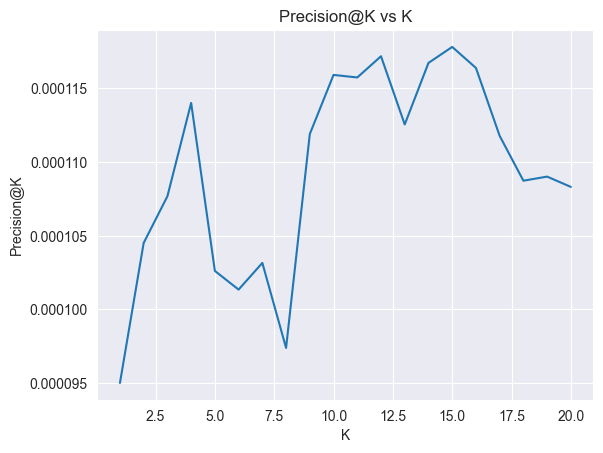

In [42]:
# --- Figure 1: Precision@K vs K ---
plt.figure()
plt.plot(k_values, prec_k)
plt.xlabel("K")
plt.ylabel("Precision@K")
plt.title("Precision@K vs K")
plt.show()


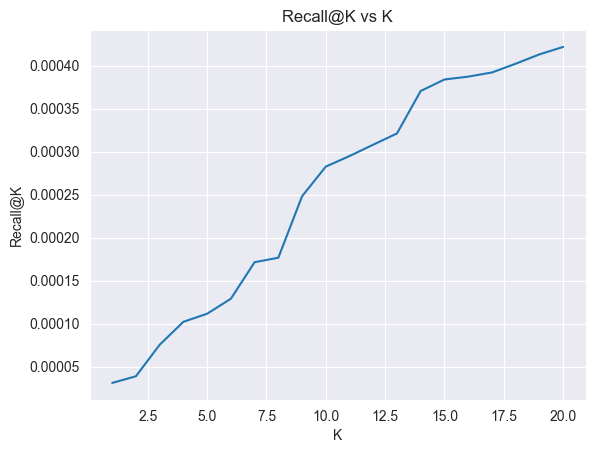

In [43]:
# --- Figure 2: Recall@K vs K ---
plt.figure()
plt.plot(k_values, rec_k)
plt.xlabel("K")
plt.ylabel("Recall@K")
plt.title("Recall@K vs K")
plt.show()


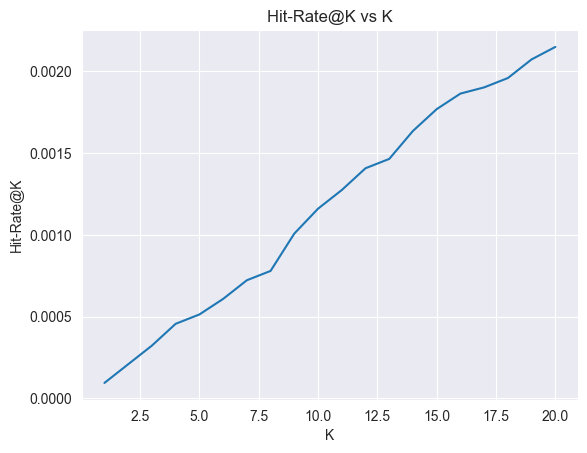

In [44]:
# --- Figure 3: Hit-Rate@K vs K ---
plt.figure()
plt.plot(k_values, hit_k)
plt.xlabel("K")
plt.ylabel("Hit-Rate@K")
plt.title("Hit-Rate@K vs K")
plt.show()


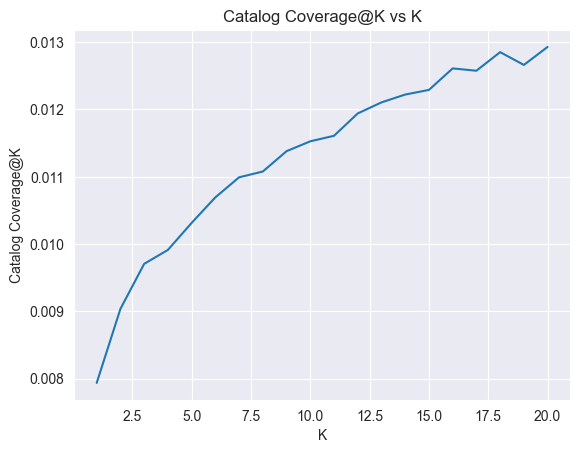

In [45]:
# --- Figure 4: Catalog Coverage@K vs K ---
plt.figure()
plt.plot(k_values, coverage_frac)
plt.xlabel("K")
plt.ylabel("Catalog Coverage@K")
plt.title("Catalog Coverage@K vs K")
plt.show()


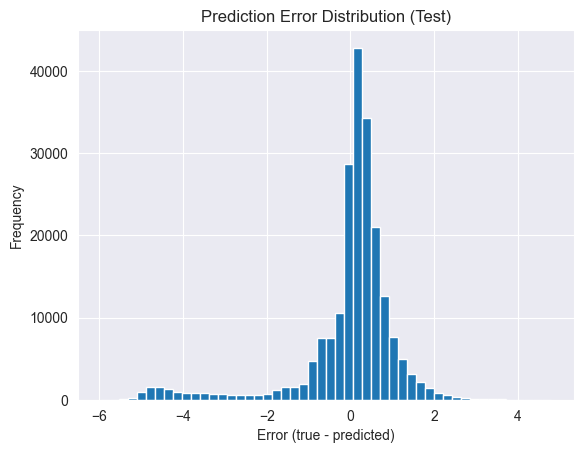

In [46]:
# --- Figure 5: Prediction error distribution on test (true - pred) ---
y_true = test[COLS["rating"]].to_numpy(np.float64)
y_pred = mf.predict_many(test["_uid"].to_numpy(np.int64), test["_iid"].to_numpy(np.int64))
residuals = y_true - y_pred

plt.figure()
plt.hist(residuals, bins=50)
plt.xlabel("Error (true - predicted)")
plt.ylabel("Frequency")
plt.title("Prediction Error Distribution (Test)")
plt.show()


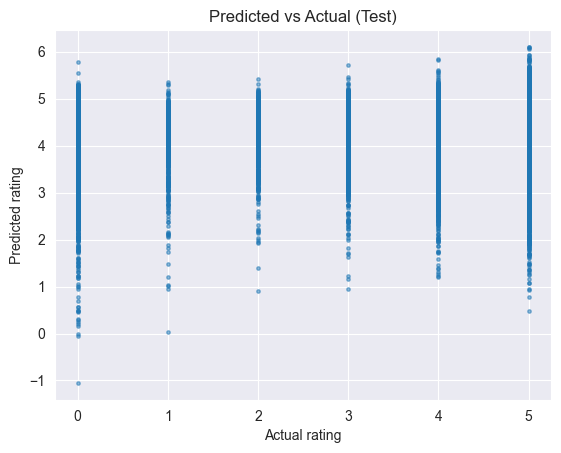

In [47]:
# --- Figure 6: Predicted vs Actual (sampled for readability) ---
N_SAMPLE = min(50000, len(test))
idx = np.random.default_rng(42).choice(len(test), size=N_SAMPLE, replace=False) if len(test) > N_SAMPLE else np.arange(len(test))

plt.figure()
plt.scatter(y_true[idx], y_pred[idx], s=6, alpha=0.5)
plt.xlabel("Actual rating")
plt.ylabel("Predicted rating")
plt.title("Predicted vs Actual (Test)")
plt.show()


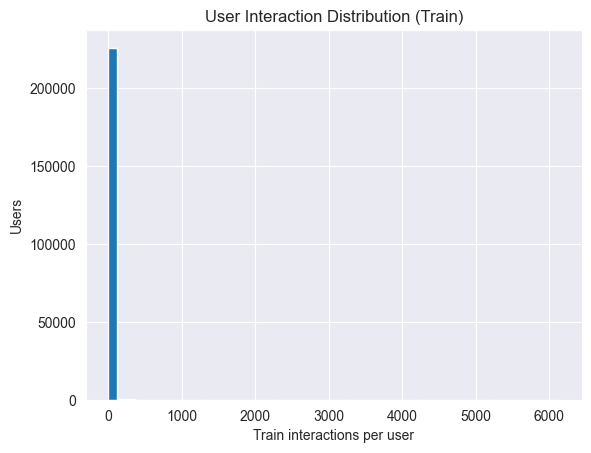

In [48]:
# --- Figure 7: User interaction distribution (train interactions per user) ---
train_counts = pd.Series([len(v) for v in train_by_user.values()], dtype=float)

plt.figure()
plt.hist(train_counts, bins=50)
plt.xlabel("Train interactions per user")
plt.ylabel("Users")
plt.title("User Interaction Distribution (Train)")
plt.show()


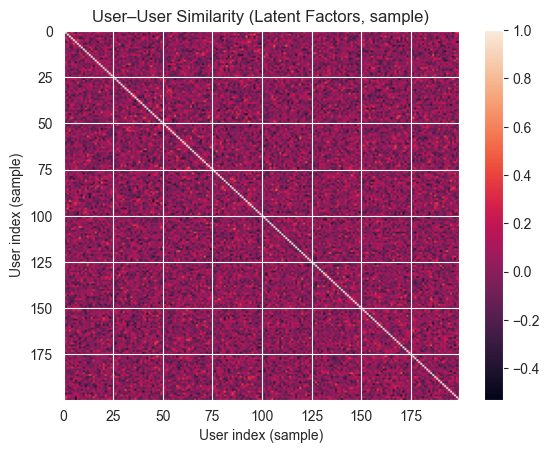

In [49]:
# --- Figure 8: User–User similarity heatmap (sample) ---
# cosine similarity over latent factors P (normalized), sample up to 200 users
SAMPLE_U = min(200, len(users_eval))
u_sample = np.random.default_rng(42).choice(users_eval, size=SAMPLE_U, replace=False) if len(users_eval) > SAMPLE_U else np.array(users_eval)

Pu = mf.P[u_sample]
norms = np.linalg.norm(Pu, axis=1, keepdims=True) + 1e-12
Pu_norm = Pu / norms
sim = Pu_norm @ Pu_norm.T

plt.figure()
plt.imshow(sim, aspect="auto")
plt.colorbar()
plt.title("User–User Similarity (Latent Factors, sample)")
plt.xlabel("User index (sample)")
plt.ylabel("User index (sample)")
plt.show()
